In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
import glob
from collections import defaultdict
import re


import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

import pvlib
from pvlib.solarposition import get_solarposition
from pvlib.irradiance import get_extra_radiation as E0_pvlib
from sklearn.neighbors import KDTree

from utils import read_weather,read_radiation, load_ucdb_city
from data_processor import compute_annual_and_daily_cycles
from plots import plot_annual_cycles_summary, plot_diurnal_cycles_summary

## Parameters

In [3]:
weather_path = "Observed_Meteorology_Paris_France_CdG_Airport_WBAN_071570_2000-24/Weather.csv"         # change if needed
radiation_path = "Observed_Meteorology_Paris_France_CdG_Airport_WBAN_071570_2000-24/Radiation.csv"     # optional; change if needed
base_path = "/lustre/gmeteo/DATA/ESGF/REPLICA/DATA/cordex/output/EUR-11/*/*/historical/*/*/v*/3hr/{variable}/*/*200*"

#Constants
I_sc = 1367.0  # solar constant [W/m^2]
a, b = 17.27, 237.7  # Constants for the Magnus formula approximation used in dew point calculation.
eps = 1e-9

#Dat for observations
lat = 49.0097
lon = 2.5479   
start_date = "2000-01-01"
end_date  = "2024-12-30"

#Model
institution='KNMI'
RCM= 'NCC-NorESM1-M'
model= 'RACMO22E'
version = 'v1'
ensemble= 'r1i1p1'

In [4]:
# List of variables to analyze, mapped to DataFrame column names
variables = {
    'Shortwave Direct': 'Radiation_Shortwave_Direct_Wpm2(W/m^2)',
    'Shortwave Diffuse': 'Radiation_Shortwave_Diffuse_Wpm2(W/m^2)',
    'Longwave Downwelling': 'Radiation_Longwave_Downwelling_Wpm2(W/m^2)',
    'Longwave Upwelling': 'Radiation_Longwave_Upwelling_Wpm2(W/m^2)',
    'Net Radiation': 'Radiation_Net_Wpm2(W/m^2)',
    'Air Temperature': 'Temperature_Air_F(F)',
    'DewPoint Temperature': 'Temperature_DewPoint_F(F)',
    'Wind Speed': 'Wind_Speed_mps(m/s)',
    'Atmospheric Pressure': 'Pressure_Atmosphere_kPa(kPa)',
    'Precipitation Rate': 'Precipitation_Rate_mph(m/h)'
}


variables_obs = {
    # Calculated variables
    'Shortwave Downwelling': 'Radiation_Shortwave_Downwelling_Wpm2(W/m^2)', # rsds (GHI)
    'Shortwave Direct':      'Radiation_Shortwave_Direct_downwelling_Wpm2(W/m^2)',
    'Shortwave Diffuse':     'Radiation_Shortwave_Diffuse_downwelling_Wpm2(W/m^2)',
    'Shortwave Upwelling':   'Radiation_Shortwave_Upwelling_Wpm2(W/m^2)', # rsus
    'Longwave Downwelling':  'Radiation_Longwave_Downwelling_Wpm2(W/m^2)', # rlds
    'Longwave Upwelling':    'Radiation_Longwave_Upwelling_Wpm2(W/m^2)', # rlus
    'Net Radiation':         'Radiation_Net_Wpm2(W/m^2)',
    'Air Temperature':       'Temperature_Air_F(F)',
    'DewPoint Temperature':  'Temperature_DewPoint_F(F)',
    'Wind Speed':            'Wind_Speed_mps(m/s)',
    'Atmospheric Pressure':  'Pressure_Atmosphere_kPa(kPa)',
    'Precipitation Rate':    'Precipitation_Rate_mph(m/h)',
    'Relative Humidity':     'Humidity_Relative_pct(%)',
    'Total Cloud Fraction':  'Cloud_Fraction_Total_pct(%)',
}


variables_plot = {
    'Shortwave Direct':      'Radiation_Shortwave_Direct',
    'Shortwave Diffuse':     'Radiation_Shortwave_Diffuse',
    'Longwave Downwelling':  'Radiation_Longwave_Downwelling',
    'Longwave Upwelling':    'Radiation_Longwave_Upwelling',
    'Net Radiation':         'Radiation_Net',
    'Air Temperature':       'Temperature_Air_F',
    'DewPoint Temperature':  'Temperature_DewPoint_F',
    'Wind Speed':            'Wind_Speed_mps',
    'Atmospheric Pressure':  'Pressure_Atmosphere_kPa',
    'Precipitation Rate':    'Precipitation_Rate_mph',
}


## Functions

### Output directories

In [5]:
# --- Define Directory Names ---
data_dir = "data"
plots_dir = "plots"

try:
    os.makedirs(data_dir, exist_ok=True)
    print(f"Directory '{data_dir}' ensured.")
except Exception as e:
    print(f"Error creating directory '{data_dir}': {e}")

try:
    os.makedirs(plots_dir, exist_ok=True)
    print(f"Directory '{plots_dir}' ensured.")
except Exception as e:
    print(f"Error creating directory '{plots_dir}': {e}")

Directory 'data' ensured.
Directory 'plots' ensured.


## Create dataframe for observations

### Weather data

In [6]:
# Load data
df_w = read_weather(weather_path)

# normalize columns names (strip spaces)
df_w.columns = [c.strip() for c in df_w.columns]

# attempt to detect datetime columns and create datetime
if "YYYYMMDD" in df_w.columns and "HH:MM:SS" in df_w.columns:
    # some files may have integer YYYYMMDD
    df_w["YYYYMMDD"] = df_w["YYYYMMDD"].astype(str)
    df_w["datetime"] = pd.to_datetime(df_w["YYYYMMDD"].str.zfill(8) + " " + df_w["HH:MM:SS"])
else:
    # try to find a generic datetime column
    df_w["datetime"] = pd.to_datetime(df_w[possible[0]])

### Radiation data

In [7]:
# load radiation if present
df_rad = read_radiation(radiation_path)
if df_rad is not None:
    df_rad.columns = [c.strip() for c in df_rad.columns]
    # try to create datetime in rad file in same way (so we can merge)
    if "YYYYMMDD" in df_rad.columns and "HH:MM:SS" in df_rad.columns:
        df_rad["YYYYMMDD"] = df_rad["YYYYMMDD"].astype(str)
        df_rad["datetime"] = pd.to_datetime(df_rad["YYYYMMDD"].str.zfill(8) + " " + df_rad["HH:MM:SS"])
    else:
        df_rad["datetime"] = pd.to_datetime(df_rad[poss[0]])

### Concat weather and radiation

In [8]:
if df_rad["datetime"].notnull().any():
    df = pd.merge(df_w, df_rad.drop(columns=[c for c in df_rad.columns if c=="datetime" and c not in df_w.columns]),
                  on="datetime", how="left", suffixes=("","_rad"))
else:
    df = pd.concat([df_w.reset_index(drop=True), df_rad.reset_index(drop=True)], axis=1)

df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

## Fix bug
During the analysis of the Diurnal Cycle for the Precipitation_Rate_mph(m/h) variable, a critical data quality issue was identified. The hourly mean calculation revealed a non-physical, periodic pattern where the average precipitation rate was exactly zero (or extremely close to zero) during specific hours.

A subsequent verification confirmed that for the hours 1, 4, 7, 10, 13, 16, 19, and 22, the DataFrame contains zero positive precipitation events across the entire time series.

In [9]:
mask = (df['Precipitation_Rate_mph(m/h)'] == 0.0) & (df.index.hour.isin([1, 4, 7, 10, 13, 16, 19, 22]))
df.loc[mask, 'Precipitation_Rate_mph(m/h)'] = np.nan

In [10]:
df['tas']=df["Temperature_Air_F(F)"]

## Calculate Annual cycles

In [11]:
annual_cycles = {}
daily_cycles = {}

for name, col in variables.items():
    
    # Extract variable series and remove NaN values
    data_series = df[col].dropna()
    
    if name == 'Precipitation Rate':
        
        # ---- Annual cycle (monthly totals) ----
        # Sum all hourly values in each month → gives total mm per month
        annual_cycles[name] = data_series.groupby(data_series.index.month).mean()

        # ---- Daily cycle (hourly mean) ----
        # For typical daily cycle, take mean over all days for each hour
        daily_precip_series = data_series.groupby(data_series.index.hour).mean()

        # Optional: replace zero-intensity hours with NaN
        daily_precip_series.replace(0.0, np.nan, inplace=True)

        daily_cycles[name] = daily_precip_series

    else:
        # Annual and daily cycles for other variables: mean
        annual_cycles[name] = data_series.groupby(data_series.index.month).mean()
        daily_cycles[name] = data_series.groupby(data_series.index.hour).mean()


## Comparison with model

## Extract the cordex serie

In [12]:
annual_cycles_mod, daily_cycles_mod = compute_annual_and_daily_cycles(
    data_dir=data_dir,
    variables_obs=variables_obs,
    filename_pattern="df_*.csv"
)

Found 12 CSV files.

Processing model: CLMcom-ETH_MPI-M-MPI-ESM-LR_r1i1p1_COSMO-crCLIM-v1-1_v1

Processing model: MOHC_MOHC-HadGEM2-ES_r1i1p1_HadREM3-GA7-05_v1

Processing model: CNRM_MOHC-HadGEM2-ES_r1i1p1_ALADIN63_v1

Processing model: KNMI_MPI-M-MPI-ESM-LR_r1i1p1_RACMO22E_v1

Processing model: CNRM_NCC-NorESM1-M_r1i1p1_ALADIN63_v1

Processing model: CLMcom-ETH_NCC-NorESM1-M_r1i1p1_COSMO-crCLIM-v1-1_v1

Processing model: MOHC_MPI-M-MPI-ESM-LR_r1i1p1_HadREM3-GA7-05_v1

Processing model: KNMI_MOHC-HadGEM2-ES_r1i1p1_RACMO22E_v2

Processing model: CNRM_MPI-M-MPI-ESM-LR_r1i1p1_ALADIN63_v1

Processing model: CLMcom-ETH_MOHC-HadGEM2-ES_r1i1p1_COSMO-crCLIM-v1-1_v1

Processing model: KNMI_NCC-NorESM1-M_r1i1p1_RACMO22E_v1

Processing model: MOHC_NCC-NorESM1-M_r1i1p1_HadREM3-GA7-05_v1

Finished computing cycles PER MODEL.



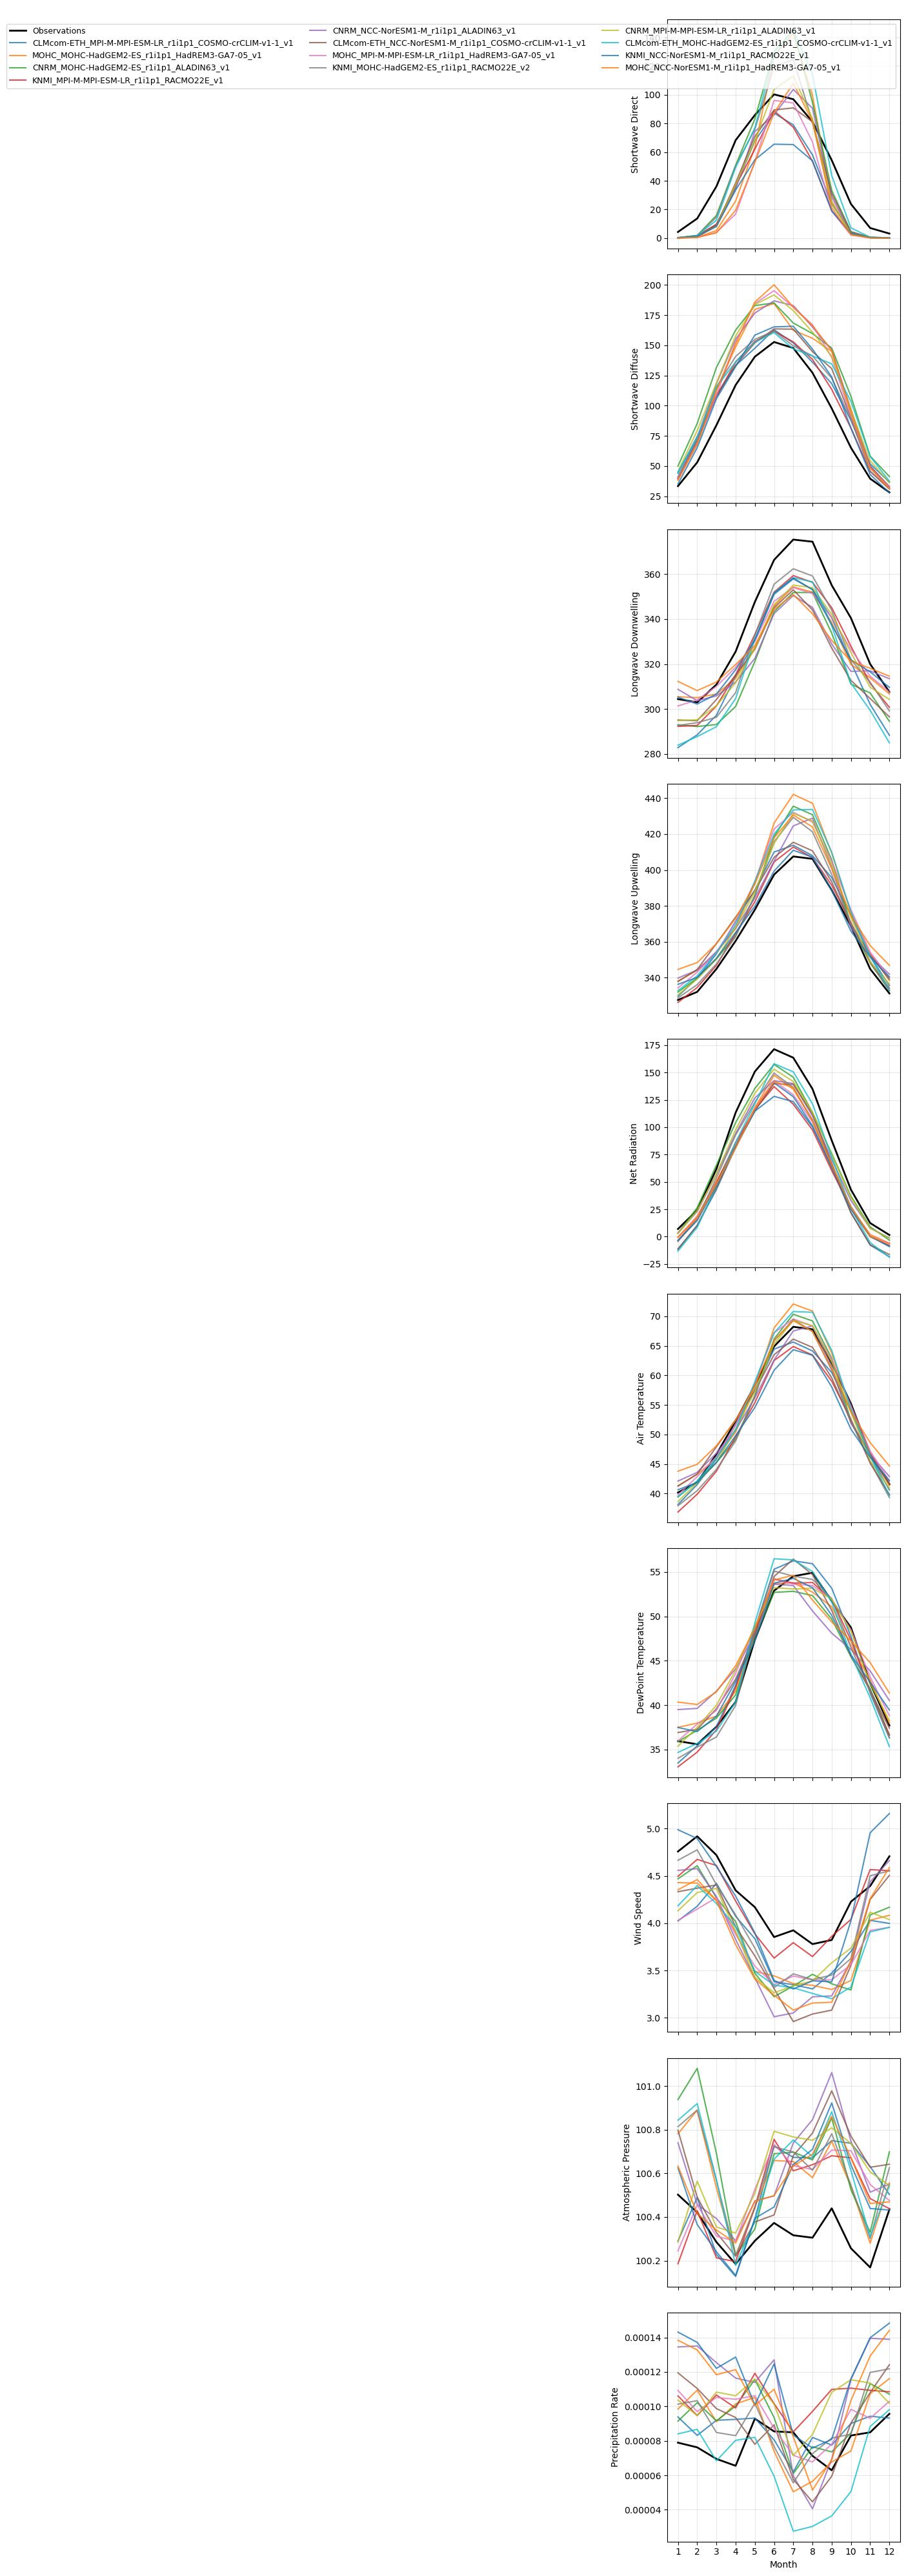

In [13]:
fig = plot_annual_cycles_summary(
    annual_cycles_mod,
    annual_cycles,
    variables_plot
)

fig.savefig(f"{plots_dir}/annual_cycles_summary.png", dpi=300, bbox_inches="tight")


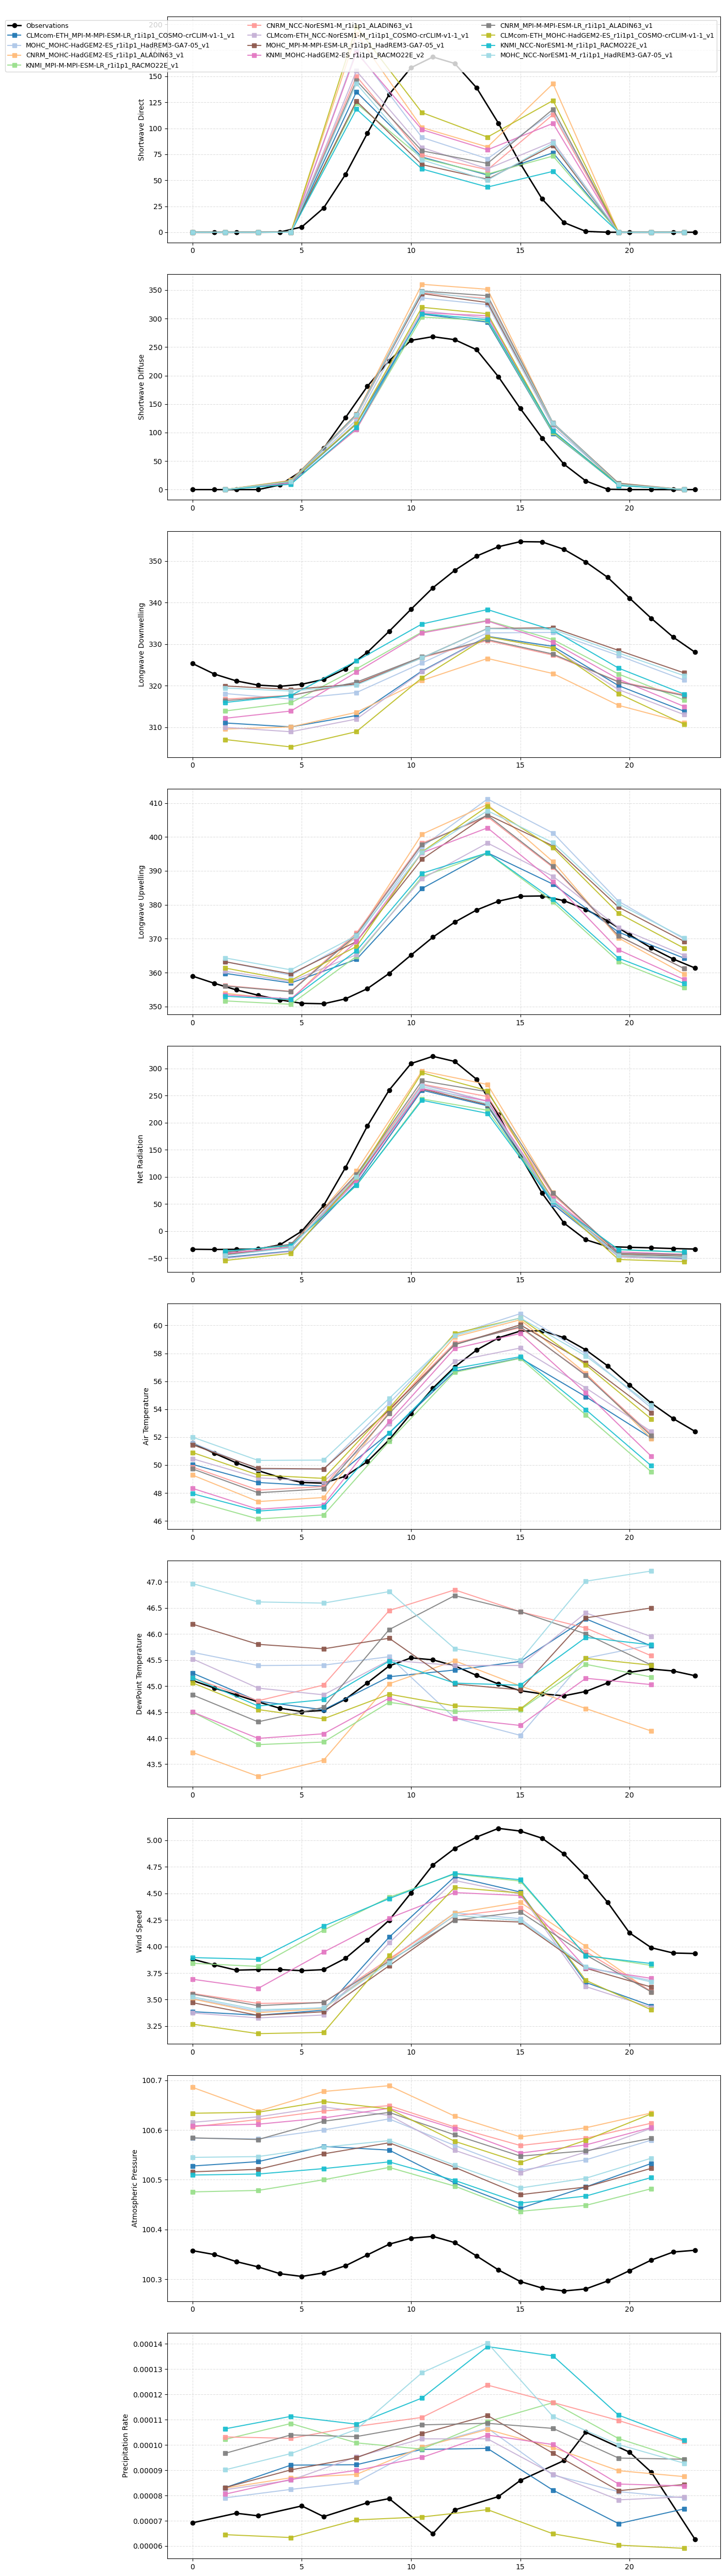

In [14]:
fig = plot_diurnal_cycles_summary(daily_cycles_mod, daily_cycles, variables_plot)
fig.savefig(f"{plots_dir}/daily_cycle_summary.png", dpi=300)